In [29]:
import os, math
from collections import defaultdict
import itertools
import sqlite3

import logging
import logging.handlers

from PIL import Image, ImageDraw
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy
import numpy as np
import cupy as cp
import pandas as pd

from utils import *
from hdc import *

In [30]:
config = Config('SQLITE3')
RNG = np.random.default_rng()

if cp.cuda.is_available():
    device_marker = cp.empty(1)
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    device_marker = np.empty(1)
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    
xp = cp.get_array_module(device_marker)
print(f'xp = {xp.__name__}')

log = logging.getLogger('MyLogger')
log.setLevel(logging.DEBUG)
log.addHandler(logging.handlers.SysLogHandler(address = '/dev/log'))

train_db_con = sqlite3.connect(os.path.join(config.dataset_path, config.train_db_file_name))
test_db_con = sqlite3.connect(os.path.join(config.dataset_path, config.test_db_file_name))

xp = cupy


In [3]:
%time
df_train_images = pd.read_sql_query('SELECT * FROM images', con=train_db_con, index_col='image_id')
df_test_images = pd.read_sql_query('SELECT * FROM images', con=test_db_con, index_col='image_id')
df_train_images.shape, df_test_images.shape

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 3.81 μs


((10000, 3), (2000, 3))

In [4]:
df_train_images.head()

,index,value,png
image_id,,,
27456,0,2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
50770,1,3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
9353,2,4,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
50328,3,0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
18785,4,3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...


In [5]:
def matrix_to_image(m):
    m = m.ravel()
    sz = int(np.sqrt(m.shape[0]))
    assert sz * sz == m.shape[0]
    return Image.frombytes('L', size=(sz, sz), data=m.astype('b'))

In [6]:
def lay_grid(image, step):
    draw = ImageDraw.Draw(image)

    for c in range(step - 1, image.height, step):
        draw.line([0, c, image.width, c], fill=127)
        draw.line([c, 0, c, image.height], fill=127)

    return image


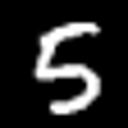
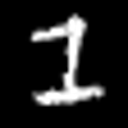
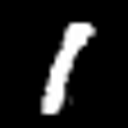
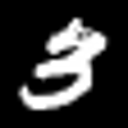
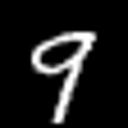
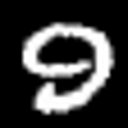
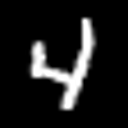
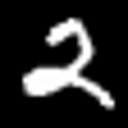
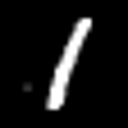
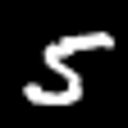
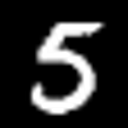
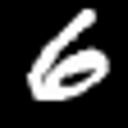
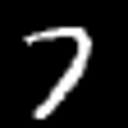
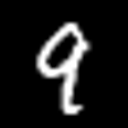
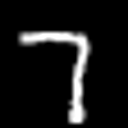
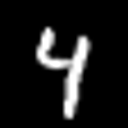

In [7]:
count = 8

def get_some_random_images_and_labels(df, count):
    image_ids = RNG.choice(df.index.unique(), count, replace=False)
    image_datas = df.loc[image_ids]['png']
    images = [Image.open(io.BytesIO(image_data)) for image_data in image_datas]
    labels = df.loc[image_ids]['value']
    return images, list(labels)

train_images, train_labels = get_some_random_images_and_labels(df_train_images, count)
test_images, test_labels = get_some_random_images_and_labels(df_test_images, count)

display_images_grid(train_images + test_images, captions=train_labels + test_labels, col_count=count)

In [8]:
#COS_SIM_THRESHOLD = 0.075
COS_SIM_THRESHOLD = 0.055
hdc = Hdc(10_000, np)

In [9]:
class CorticalColumn(object):
    def __init__(self):
        self.clusters = defaultdict(list) # cluster = collection of image bundles for particular class
        self.cluster_norms = HdvArray(hdc.N, xp)
        self.cluster_to_image_ids = defaultdict(set)

In [49]:
COLUMN = CorticalColumn()
TRAIN_RUN_ID = 0
TEST_RUN_ID = 0

COLUMN = CorticalColumn()
df_train_progress = pd.DataFrame(columns=['count', 'infers', 'correct_infers'])
df_conso_progress = pd.DataFrame(columns=['train_run_id', 'trial', 'stage', 'cluster_id', 'len'])
df_test_results = pd.DataFrame(columns=['test_run_id', 'test_image_id', 'true_value', 'cluster_id', 'infer_value', 'sim'])

In [56]:
# TRAIN RUN
TRAIN_RUN_ID += 1
trials = 3
count = 1000

for trial in tqdm(range(trials)):
    train_step_image_ids = RNG.choice(df_train_images.index.unique(), count, replace=False)

    # EVOLVE MEMORIES
    for image_no, image_id in tqdm(enumerate(train_step_image_ids), leave=False, total=len(train_step_image_ids)):
        log.debug(f'[train_run_id={TRAIN_RUN_ID}, image_no={image_no}, image_id={image_id}] Cluster count={COLUMN.cluster_norms.len()}')
        
        image_value = df_train_images.loc[image_id]['value']
        df_image_encodings = pd.read_sql('SELECT hdv FROM image_encodings WHERE image_id=:image_id', params={'image_id': int(image_id)}, con=train_db_con)
        assert len(df_image_encodings) > 0
        image_encoding_hdvs = list(map(lambda h: np.frombuffer(h, dtype='b'), df_image_encodings['hdv']))
        image_encoding_hdvs_norm = hdc.normalize(image_encoding_hdvs)
        image_encoding_hdvs_norm = xp_array_to_gpu(image_encoding_hdvs_norm)

        attempts_to_get_proper_recognition = 5

        for att_no in range(attempts_to_get_proper_recognition):
            log.debug(f'[train_run_id={TRAIN_RUN_ID}, image_no={image_no}, image_id={image_id}] att. {att_no}')
            
            cos_sim_matrix = COLUMN.cluster_norms.array @ image_encoding_hdvs_norm.T
            max_cos_sim_index = xp.argmax(cos_sim_matrix)
            max_cos_sim_index = xp.unravel_index(max_cos_sim_index, cos_sim_matrix.shape)
            assert len(max_cos_sim_index) == 2 # must be a pair tuple
            
            if cos_sim_matrix[tuple(max_cos_sim_index)] >= COS_SIM_THRESHOLD:
                hdv_index = int(max_cos_sim_index[1])
                hdv = image_encoding_hdvs[hdv_index]
                
                winner_cluster_id = int(max_cos_sim_index[0])
                winner_cluster_hdvs = COLUMN.clusters[cluster_index] # list
                winner_cluster_image_ids = COLUMN.cluster_to_image_ids[winner_cluster_id]
                assert len(winner_cluster_image_ids) > 0
                winner_cluster_image_id = next(iter(winner_cluster_image_ids))
                winner_cluster_image_value = df_train_images.loc[winner_cluster_image_id]['value']

                log.debug(f'[train_run_id={TRAIN_RUN_ID}, image_no={image_no}, image_id={image_id}] Max cos sim={cos_sim_matrix[tuple(max_cos_sim_index)]:.2f}, cluster #{winner_cluster_id} ({len(winner_cluster_hdvs)}), infer value={winner_cluster_image_value}, true value={image_value}')
                
                if winner_cluster_image_value == image_value:
                    log.debug(f'[train_run_id={TRAIN_RUN_ID}, image_no={image_no}, image_id={image_id}] Best match success!')
                    winner_cluster_image_ids.add(image_id)
                    winner_cluster_hdvs.append(hdv)
                    new_bundle = xp_array_to_gpu(hdc.bundle(winner_cluster_hdvs))
                    COLUMN.cluster_norms.array[cluster_index] = hdc.normalize(new_bundle)
                    break # Correct match found, relax outselves!
                else:
                    log.debug(f'[train_run_id={TRAIN_RUN_ID}, image_no={image_no}, image_id={image_id}] Debundle!')
                    winner_cluster_hdvs.append(hdc.complement(hdv))
                    new_bundle = xp_array_to_gpu(hdc.bundle(winner_cluster_hdvs))
                    COLUMN.cluster_norms.array[cluster_index] = hdc.normalize(new_bundle)
                

            # # Incorrect cluster was recalled, correct memory
            # cos_sim_matrix *= -1 # for desc sort
            # cos_sim_matrix.sort(axis=0) # sort each column desc
            # cos_sim_matrix *= -1 
            # cos_sim_indices = xp.argwhere(cos_sim_matrix >= COS_SIM_THRESHOLD)
    
            # for cos_sim_index in cos_sim_indices:
            #     log.debug(f'[train_run_id={TRAIN_RUN_ID}, image_no={image_no}, image_id={image_id}] Handling cluster #{cos_sim_index[0]} for enc_hdv #{cos_sim_index[1]} sim {cos_sim_matrix[tuple(cos_sim_index)]:.2f}')
            
            #     assert cos_sim_index.shape == (2,)
            #     cos_sim_index = tuple(cos_sim_index)
            #     hdv_index = int(cos_sim_index[1])
            #     hdv = image_encoding_hdvs[hdv_index]
            #     cluster_index = int(cos_sim_index[0])
            #     similar_cluster = COLUMN.clusters[cluster_index] # list
            #     similar_cluster_image_ids = COLUMN.cluster_to_image_ids[cluster_index]
            #     assert len(similar_cluster_image_ids) > 0
            #     similar_cluster_image_id = next(iter(similar_cluster_image_ids)) # pick any
            #     similar_cluster_image_value = df_train_images.loc[similar_cluster_image_id]['value']

            #     if similar_cluster_image_value != image_value:
            #         log.debug(f'[train_run_id={TRAIN_RUN_ID}, image_no={image_no}, image_id={image_id}] Debundle')
            #         # Debundle from cluster which showed similarity but actually is not
            #         similar_cluster.append(hdc.complement(hdv))
            #         COLUMN.cluster_norms.array[cluster_index] = xp_array_to_gpu(hdc.normalize(hdc.bundle(similar_cluster)))
            #     else:
            #         log.debug(f'[train_run_id={TRAIN_RUN_ID}, image_no={image_no}, image_id={image_id}] Bundle')                    
            #         # Bundle with cluster which showed real similarity
            #         similar_cluster_image_ids.add(image_id)
            #         similar_cluster.append(hdv)
            #         COLUMN.cluster_norms.array[cluster_index] = xp_array_to_gpu(hdc.normalize(hdc.bundle(similar_cluster)))
        else:
            # Didn't find any matching cluster of HDVs to join -> create new one
            cluster_id = COLUMN.cluster_norms.lease()
            hdv_index_to_remember = 0
            COLUMN.cluster_norms.array[cluster_id] = image_encoding_hdvs_norm[hdv_index_to_remember]
            COLUMN.clusters[cluster_id].append(image_encoding_hdvs[hdv_index_to_remember])
            COLUMN.cluster_to_image_ids[cluster_id].add(image_id)
            log.debug(f'[train_run_id={TRAIN_RUN_ID}, image_no={image_no}, image_id={image_id}] created new cluster {cluster_id}')

    # CONSOLIDATE MEMORY
    for cluster_index, image_ids in COLUMN.cluster_to_image_ids.items():
        df_conso_progress.loc[len(df_conso_progress)] = [TRAIN_RUN_ID, trial, 'before', cluster_index, len(image_ids)]
    
    before_len = COLUMN.cluster_norms.len()
    assert before_len == len(COLUMN.clusters)
    cluster_indices_to_release = []
    
    for cluster_index, image_ids in COLUMN.cluster_to_image_ids.items():
        l = 1
        exp_distro_level = l * np.exp(-l * len(image_ids))
        rand_level = RNG.random()
        do_release = rand_level < exp_distro_level
        
        if do_release:
            cluster_indices_to_release.append(cluster_index)

    for cluster_index_to_release in cluster_indices_to_release:
        del COLUMN.clusters[cluster_index_to_release]
        del COLUMN.cluster_to_image_ids[cluster_index_to_release]
        COLUMN.cluster_norms.release(cluster_index_to_release)

    after_len = COLUMN.cluster_norms.len()
    assert after_len == len(COLUMN.clusters)
    
    for cluster_index, image_ids in COLUMN.cluster_to_image_ids.items():
        df_conso_progress.loc[len(df_conso_progress)] = [TRAIN_RUN_ID, trial, 'after', cluster_index, len(image_ids)]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [57]:
# TEST RUN
TEST_RUN_ID += 1
count = 500
test_image_ids = RNG.choice(df_test_images.index.unique(), count, replace=False)
#test_image_ids = [100007372]
test_result_rows = []

for image_id in tqdm(test_image_ids):
    image_value = df_test_images.loc[image_id]['value']
    df_image_encodings = pd.read_sql('SELECT hdv FROM image_encodings WHERE image_id=:image_id', params={'image_id': int(image_id)}, con=test_db_con)
    assert len(df_image_encodings) > 0
    image_encoding_hdvs = map(lambda h: np.frombuffer(h, dtype='b'), df_image_encodings['hdv'])
    max_cos_sim_index = -1 # aka cluster id
    max_similar_cluster_image_value = ''
    max_cos_sim = 0

    for image_encoding_hdv in image_encoding_hdvs:
        image_encoding_hdv_norm = hdc.normalize(image_encoding_hdv)
        image_encoding_hdv_norm = xp_array_to_gpu(image_encoding_hdv_norm)
        cos_sims = COLUMN.cluster_norms.array @ image_encoding_hdv_norm
        this_max_cos_sim_index = int(xp.argmax(cos_sims))
        this_max_cos_sim = xp_array_from_gpu(cos_sims[this_max_cos_sim_index])

        if cos_sims[this_max_cos_sim_index] < COS_SIM_THRESHOLD:
            continue

        if this_max_cos_sim > max_cos_sim:
            max_cos_sim = this_max_cos_sim
            max_cos_sim_index = this_max_cos_sim_index
            similar_cluster_image_ids = COLUMN.cluster_to_image_ids[max_cos_sim_index]
            assert len(similar_cluster_image_ids) > 0
            similar_cluster_image_id = next(iter(similar_cluster_image_ids))
            max_similar_cluster_image_value = df_train_images.loc[similar_cluster_image_id]['value'] # exactly from train! (i.e. we look for prototype in train data)
    
    test_result_rows.append([TEST_RUN_ID, image_id, image_value, max_cos_sim_index, max_similar_cluster_image_value, max_cos_sim])

df_test_results_for_run = pd.DataFrame(test_result_rows, columns=df_test_results.columns)
concat_list = [df_test_results] if len(df_test_results) > 0 else []
concat_list.append(df_test_results_for_run)
df_test_results = pd.concat(concat_list, ignore_index=True)

  0%|          | 0/500 [00:00<?, ?it/s]

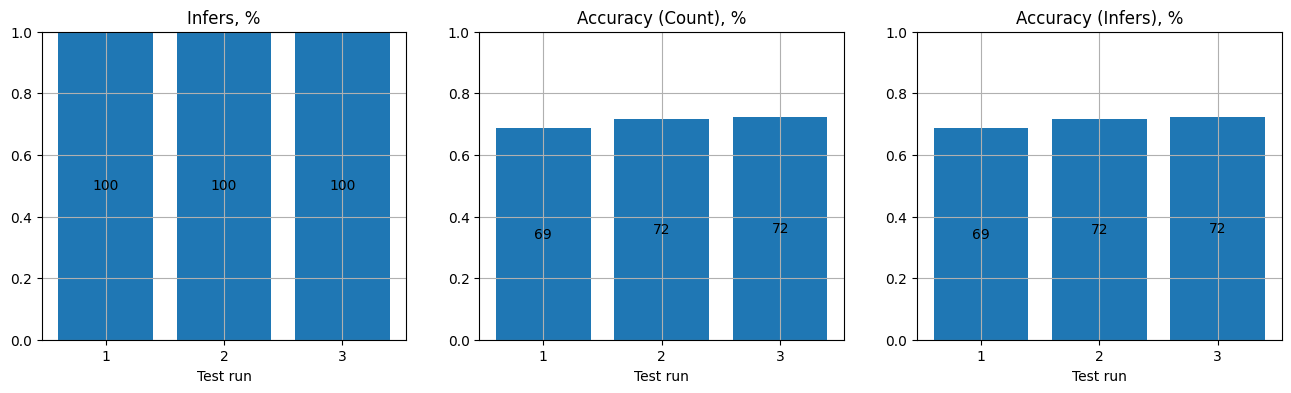

,count,infers,correct_infers,infer_ratio,accuracy_count,accuracy_infers
test_run_id,,,,,,
1,500,500,343,1.0,0.686,0.686
2,500,500,359,1.0,0.718,0.718
3,500,500,362,1.0,0.724,0.724


In [58]:
df_test_results2 = df_test_results.copy()
df_test_results2['is_infer'] = df_test_results2['cluster_id'] > -1
df_test_results2['is_correct_infer'] = df_test_results2['true_value'] == df_test_results2['infer_value']
df_test_results2 = df_test_results2.groupby(by=['test_run_id']).agg({'test_image_id': 'count', 'is_infer': 'sum', 'is_correct_infer': 'sum'})
df_test_results2.rename(columns=dict(test_image_id='count', is_infer='infers', is_correct_infer='correct_infers'), inplace=True, errors='raise')
df_test_results2['infer_ratio'] = df_test_results2['infers'] / df_test_results2['count']
df_test_results2['accuracy_count'] = df_test_results2['correct_infers'] / df_test_results2['count']
df_test_results2['accuracy_infers'] = df_test_results2['correct_infers'] / df_test_results2['infers']

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['infer_ratio']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['infer_ratio']), label_type='center')
plt.ylim(0, 1)
plt.title('Infers, %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 2)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_count']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_count']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Count), %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 3)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_infers']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_infers']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Infers), %')
plt.xlabel('Test run')
plt.grid()

plt.show()
df_test_results2


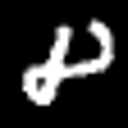

In [40]:
images = []
captions = []

if COLUMN.clusters.keys():
    random_cluster_i = RNG.choice(list(COLUMN.clusters.keys()))
    image_ids = COLUMN.cluster_to_image_ids[random_cluster_i]
    df_i = df_train_images.loc[list(image_ids)]
    image_datas = df_i['png']
    images = [Image.open(io.BytesIO(image_data)) for image_data in image_datas]
    captions = list(map(lambda p: f'clust={random_cluster_i}, #{p[0]}, val={p[1]}', zip(df_i.index, df_i['value'])))
    
display_images_grid(images, captions=captions, col_count=8)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [132]:
pd.pivot_table(df_test_results, index='true_value', columns=['is_correct_infer'], values=['test_image_id'], aggfunc=['count'])

count      
                 test_image_id      
is_correct_infer         False True 
true_value                          
0                           15   176
1                           11   219
2                           41   169
3                           20   187
4                           33   148
5                           42   135
6                           18   182
7                           26   191
8                           44   147
9                           35   161

In [155]:
df_test_results_incorrect_infers = df_test_results[df_test_results['is_correct_infer'] == False]
incorrect_infer_row_index = RNG.choice(df_test_results_incorrect_infers.index.unique())
incorrect_infer_image_id = df_test_results_incorrect_infers.loc[incorrect_infer_row_index]['test_image_id']
incorrect_infer_cluster_id = df_test_results_incorrect_infers.loc[incorrect_infer_row_index]['cluster_id']
image_data = df_test_images.loc[incorrect_infer_image_id]['png']
image_value = df_test_images.loc[incorrect_infer_image_id]['value']

df_image_encodings = pd.read_sql('SELECT hdv FROM image_encodings WHERE image_id=:image_id', params={'image_id': int(incorrect_infer_image_id)}, con=test_db_con)
assert len(df_image_encodings) > 0
image_encoding_hdvs = map(lambda h: np.frombuffer(h, dtype='b'), df_image_encodings['hdv'])
df_x = pd.DataFrame(columns=['true_value', 'cluster_id', 'cluster_value', 'sim'])

for image_encoding_hdv in image_encoding_hdvs:
    image_encoding_hdv_norm = hdc.normalize(image_encoding_hdv)
    image_encoding_hdv_norm = xp_array_to_gpu(image_encoding_hdv_norm)
    cos_sims = COLUMN.cluster_norms.array @ image_encoding_hdv_norm
    max_cos_sim_index = int(xp.argmax(cos_sims))
    max_cos_sim = xp_array_from_gpu(cos_sims[max_cos_sim_index])

    if cos_sims[max_cos_sim_index] < COS_SIM_THRESHOLD:
        continue

    similar_cluster_image_ids = COLUMN.cluster_to_image_ids[max_cos_sim_index]
    assert len(similar_cluster_image_ids) > 0
    similar_cluster_image_id = next(iter(similar_cluster_image_ids))
    similar_cluster_image_value = df_train_images.loc[similar_cluster_image_id]['value'] # exactly from train! (i.e. we look for prototype in train data)
    df_x.loc[len(df_x)] = [image_value, max_cos_sim_index, similar_cluster_image_value, max_cos_sim]

df_x.sort_values(by='sim', ascending=False)

,true_value,cluster_id,cluster_value,sim
6,6,226,0,0.10350888834976019
15,6,130,6,0.09287200673449468
5,6,12,6,0.08926529383207574
33,6,232,6,0.08635677829726608
16,6,170,6,0.08443675483565317
26,6,171,6,0.08333344602688733
19,6,273,6,0.08231992868857155
32,6,273,6,0.08171938005849835
31,6,22,6,0.0798158169628589
28,6,12,6,0.07901419290159742


In [136]:
df_test_results.loc[incorrect_infer_row_index]

test_image_id                 100007372
true_value                            5
cluster_id                           70
infer_value                           3
sim                 0.07236942128898642
is_correct_infer                  False
Name: 1983, dtype: object